In [1]:
from __future__ import annotations

import os
import string

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer

%config InlineBackend.figure_format = 'svg' 

In [2]:
RAW_DATA_FILENAME = 'reddit_ell_eng_raw_pos{}.csv'
RAW_DATA_MAXLEN = ['none', '300', '200']

In [3]:
def load_data(maxlen: str = 'none') -> pd.DataFrame:
    """Load the raw data from a csv file."""
    maxlen = f"_{maxlen}" if maxlen != "none" else ""
    df = pd.read_csv(f'{RAW_DATA_FILENAME.format(maxlen)}')
    return df


def group_shuffle_split(
    df: pd.DataFrame,
    *,
    groups: pd.Series,
    n_splits: int = 10,
    test_size: float = 0.2,
    random_state: int = 42,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Perform a group shuffle split on a dataframe."""
    gss = GroupShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(df, groups=groups))
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    return train_df, test_df


def count_punct(text: str, relative: bool = False) -> dict:
    """Extract punctuation features from a dataframe and append them to the dataframe."""
    punct_counts = {punct: 0 for punct in string.punctuation}
    for char in text:
        if char in string.punctuation:
            punct_counts[char] += 1
    if relative:
        total_count = sum(punct_counts.values())
        for punct in punct_counts:
            try:
                punct_counts[punct] /= total_count
            except ZeroDivisionError:
                pass
    return punct_counts


def plot_tfidf_features(
    df: pd.DataFrame, 
    *,
    ngram_range: tuple[int, int] = (1, 1)
) -> None:
    """Plot the TF-IDF features of a dataframe."""
    n_grams = f'{ngram_range[0]}-{ngram_range[1]}' \
              if ngram_range[0] != ngram_range[1] else ngram_range[0]
    df = df.drop('label', axis=1)
    df = df.sum().sort_values(ascending=False)
    df = df.head(20)
    df.plot.barh(zorder=3, color='C0')
    plt.title(f'Top 20 {n_grams} n-grams')
    plt.xlabel('TF-IDF')
    plt.ylabel('N-gram')
    plt.tight_layout()
    plt.grid(alpha=0.5, zorder=0)

    if not os.path.exists('figures'):
        os.makedirs('figures')
    plt.savefig(f'figures/tfidf_features_{n_grams}_punct.svg')

    plt.show()

In [4]:
for maxlen in RAW_DATA_MAXLEN:
    df = load_data(maxlen)
    print(f"{maxlen=}")
    df['punct_rel'] = df['text'].apply(count_punct, relative=True)
    df = pd.concat([df.drop(['punct_rel'], axis=1), df['punct_rel'].apply(pd.Series)], axis=1)
    print("Before:", df.shape)
    # drop columns with all zeros
    df = df.loc[:, (df != 0).any(axis=0)]
    print("After:", df.shape)
    df.to_csv(f'reddit_ell_eng_raw_pos_punct_{maxlen}.csv', index=False, encoding='utf-8')

maxlen='none'
Before: (9924, 37)
After: (9924, 36)
maxlen='300'
Before: (9912, 37)
After: (9912, 36)
maxlen='200'
Before: (9888, 37)
After: (9888, 36)


In [5]:
train_df, test_df = group_shuffle_split(df, groups=df['user_id'])

X = train_df['text']
y = train_df['label']

In [6]:
comb_df = pd.concat([train_df, test_df], axis=0)
comb_df.shape[0]

9888

## On the texts

In [7]:
vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), token_pattern=rf'\b[{string.punctuation}]\b', min_df=0.01)
X = vect.fit_transform(comb_df['text'])

In [8]:
dict(comb_df.groupby('label').groups.items())

{'ELL': Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938, 4939],
            dtype='int64', length=4944),
 'ENG': Int64Index([4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951, 4952, 4953,
             ...
             9754, 9785, 9786, 9787, 9789, 9790, 9792, 9793, 9861, 9863],
            dtype='int64', length=4944)}

In [9]:
X.shape

(9888, 7)

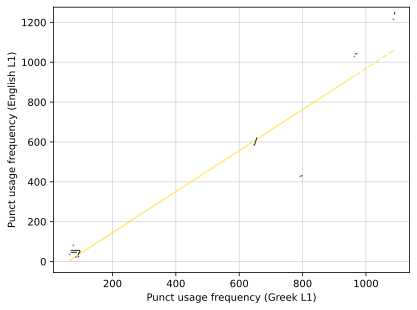

In [10]:
# sum each Punct' TF-IDF value grouped by L1
grouped = {l1: X[lang_index, :].sum(axis=0).tolist()[0] 
           for l1, lang_index in comb_df.groupby('label').groups.items()}

# convert grouped dictionary into a df using the vect Punct as index
grouped = pd.DataFrame(grouped, index=vect.get_feature_names_out())
# drop Punct that are not present in both L1
grouped = grouped.dropna()
# drop Punct that have a frequency of 0 in one of the L1
grouped = grouped[(grouped['ELL'] != 0) & (grouped['ENG'] != 0)]
# drop Punct that do not contain at least 2 alphabetic characters
# grouped = grouped[grouped.index.str.contains(r'[a-zA-Z]{2,}')]
# add a column with the difference between the two L1
grouped['diff'] = grouped.apply(lambda row: row[1] - row[0], axis=1)

fig, ax = plt.subplots()
cmap = mpl.colors.LinearSegmentedColormap.from_list('', ['#a52040', '#404080'])

# prepare Punct that will be added in the plot (L1 representation Punct)
annotations = grouped.loc[abs(grouped['diff']) > 10].reset_index()

annotations.apply(lambda row: ax.text(row['ELL'], row['ENG'], row['index']), axis=1)
ax.scatter(grouped['ELL'], grouped['ENG'], s=1, alpha=0.5, c=grouped['diff'], cmap=cmap, zorder=3)
ax.set_xlabel('Punct usage frequency (Greek L1)')
ax.set_ylabel('Punct usage frequency (English L1)')
# ax.set_xlim(0, len(grouped))
# ax.set_ylim(0, len(grouped))
ax.grid(alpha=0.5, zorder=0)

z = np.polyfit(grouped['ELL'], grouped['ENG'], 1)
p = np.poly1d(z)
plt.plot(grouped['ELL'], p(grouped['ELL']), '--', color='gold', zorder=2, alpha=0.5)

plt.show()